<h1>  Predicting stock prices </h1>

By Gani Raissov, Mugur Preda, Raman Saparkhan

In this course project, our goal is to learn how to predict if stock prices will increase or decrease using pandas and scikit-learn, and evaluate our predictions.

It's important to tie our project to the real world, and in this case, let's say that we are trading stocks. Our objective is to make profitable stock trades with minimal risk. We want to be confident that the price of a stock will increase before we buy it and sell it before the market closes. Therefore, we'll focus on developing a machine learning model that can predict whether the price of a stock will increase or decrease within a given period, with the goal of maximizing our profits and minimizing our risk.


### Machine learning setup
To predict whether the price of a stock will increase or decrease within a given period, we'll train a machine learning model using pandas and scikit-learn. The model will use historical data to predict whether or not the given stock price will grow or decrease

We want to maximize our profits while minimizing our risk, so we'll use precision as our error metric for our model, which is true positives / (false positives + true positives). This will ensure that we minimize our losses with false positives (days when we buy the stock, but the price actually goes down).

We decided to use popular indicators utilized in real-life stock market analysis as features for our machine learning algorithm. The indicators used are the following:

1. RSI (Relative Strength Index): This is an indicator that measures the strength of a stock's price movement, and helps determine if the stock is overbought or oversold. It can be used to identify potential trend reversals or to confirm trends.

2. MACD (Moving Average Convergence Divergence): This indicator is used to identify trend changes and momentum shifts in the market. It calculates the difference between two exponential moving averages (EMA) and uses a signal line (another EMA) to confirm trend changes.

3. STOCH (Stochastic Oscillator): This is a momentum indicator that compares a stock's closing price to its price range over a set period of time. It helps identify potential trend reversals and overbought or oversold conditions.

4. ADL (Accumulation/Distribution Line): This indicator measures the buying and selling pressure of a stock by taking into account both price and volume. It can help identify potential trend reversals or confirm trends.

5. ATR (Average True Range): This indicator measures the volatility of a stock by taking into account the stock's daily price range. It can be used to set stop-loss orders and determine the size of potential price moves.

6. MOM (Momentum): This is a simple indicator that measures the speed of price movements in a stock. It can help identify potential trend reversals or confirm trends.

7. MFI (Money Flow Index): This indicator measures the buying and selling pressure of a stock based on both price and volume. It can help identify potential trend reversals or confirm trends.

8. ROC (Rate of Change): This indicator measures the percentage change in a stock's price over a set period of time. It can help identify potential trend reversals or confirm trends.

9. OBV (On-Balance Volume): This indicator measures the buying and selling pressure of a stock based on volume alone. It can help identify potential trend reversals or confirm trends.

10. CCI (Commodity Channel Index): This is a momentum indicator that measures the distance between a stock's price and its moving average. It can help identify potential trend reversals or confirm trends.

11. EMV (Ease of Movement): This is a momentum indicator that takes into account both price and volume to measure the ease at which a stock is moving. It can help identify potential trend reversals or confirm trends. 

12. VORTEX (Vortex Indicator): This is a trend-following indicator that uses a combination of the true range and directional movement to identify positive and negative trends. It can help identify potential trend reversals or confirm trends.

# Data Collection

To begin, we include all of the libraries used for this project. 



In [1]:
!pip install finta 
!pip install yfinance
!pip install selenium

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings(action='ignore')

Next, we set some values that we'll use to get and process the data. The list of indicator symbols is important because it helps us create additional features for our model.

In [3]:
NUM_DAYS = 100    # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In order to collect the stock data, we have implemented a web scraper that extracts historical stock price data of a given stock from Yahoo Finance. It uses Selenium and BeautifulSoup libraries to navigate the web page and parse the HTML code to extract the table containing the historical stock price data. 

The function `getDataSet()` takes three parameters: `SYMBOL`, `NUM_DAYS`, and `INTERVAL`. `SYMBOL` is the stock symbol (e.g., MSFT for Microsoft) for which the historical stock price data is required. `NUM_DAYS` is the number of days of historical data to retrieve. `INTERVAL` is the sample rate of historical data, which can be specified as "1d" for daily, "1wk" for weekly, or "1mo" for monthly. 

The function then constructs a URL using the given parameters and retrieves the web page using the Selenium web driver. The HTML code of the web page is then parsed using BeautifulSoup to extract the table containing the historical stock price data. The extracted data is then cleaned, reformatted, and returned as a Pandas DataFrame. 



              open    high     low   close  Adj Close       volume
Date                                                              
2022-12-14  401.61  405.50  396.31  399.40     396.06  108111300.0
2022-12-15  394.30  395.25  387.89  389.63     386.37  117705900.0
2022-12-16  385.18  386.58  381.04  383.27     381.81  119858000.0
2022-12-19  383.47  383.82  378.28  380.02     378.58   79878100.0
2022-12-20  379.23  382.23  377.85  380.54     379.09   74427200.0


<Axes: xlabel='Date'>

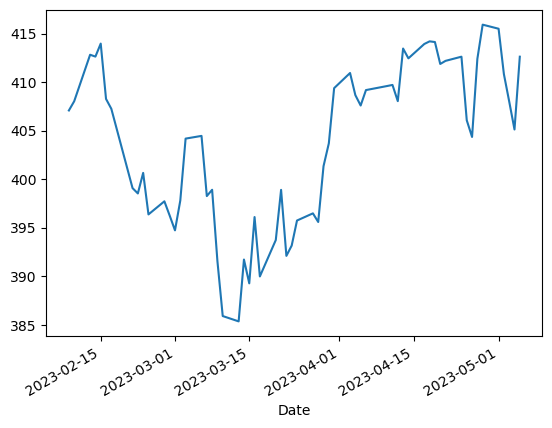

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import os
import datetime
import time
     

# SYMBOL - Symbol of the desired stock  
# NUM_DAYS - The number of days of historical data to retrieve
# INTERVAL - Sample rate of historical data 

def getDataSet(SYMBOL, NUM_DAYS, INTERVAL):
    startTime = (datetime.date.today() - datetime.timedelta( NUM_DAYS-1 ) )
    endTime = datetime.datetime.today().date()
    start = time.mktime(startTime.timetuple())
    end= time.mktime(endTime.timetuple()) 
    url = 'https://finance.yahoo.com/quote/'+SYMBOL+'/history?period1=' + str(int(start)) + '&period2='+str(int(end))+'&interval='+INTERVAL+'&filter=history&includeAdjustedClose=true'
    minus = []

    options = webdriver.ChromeOptions()
    options.add_experimental_option('excludeSwitches', ['enable-logging'])
    browser = webdriver.Chrome(options=options)
    browser.get(url)
    html = browser.page_source

    soup = BeautifulSoup(html, 'html.parser')

    table = soup.find('table')
    df = pd.read_html(str(table))[0]
    df = df[:-1]
    df = df[~df['Open'].str.contains('Dividend', regex=False)]
    df.rename(columns={"Close*": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open', 'Adj Close**': 'Adj Close'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df['close'] = df['close'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['open'] = df['open'].astype(float)
    df['Adj Close'] = df['Adj Close'].astype(float)
    return df.iloc[::-1]
    
data = getDataSet("SPY", 240, "1d")
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())
tmp = data.iloc[-60:]
tmp['close'].plot()

In [5]:
tmp.describe()

,open,high,low,close,Adj Close,volume
count,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01
mean,403.627667,406.102667,401.159000,403.782667,403.148833,9.049567e+07
std,8.315443,7.713043,8.638858,8.372655,8.689325,2.825293e+07
min,381.810000,389.490000,380.650000,385.360000,383.890000,5.522730e+07
25%,397.900000,399.380000,395.092500,396.462500,396.102500,7.053728e+07
50%,405.960000,407.675000,404.030000,405.605000,405.335000,8.547130e+07
75%,410.737500,412.995000,408.165000,411.182500,410.980000,9.825172e+07
max,415.580000,417.620000,415.270000,415.930000,415.930000,1.892530e+08


In [6]:
data.shape

(98, 6)

# Data Analysis

Let's explore the frequency of appearance of values and stationarity of the dataset

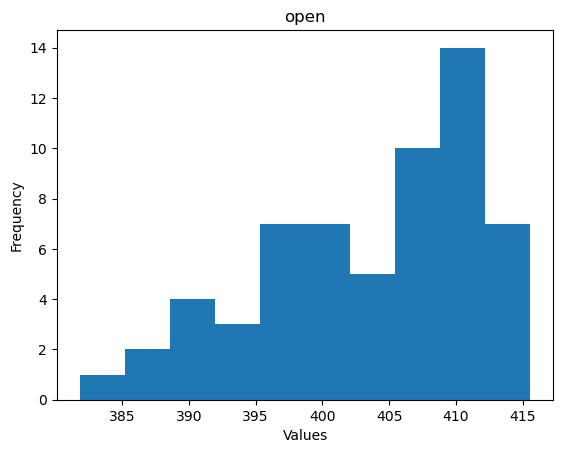

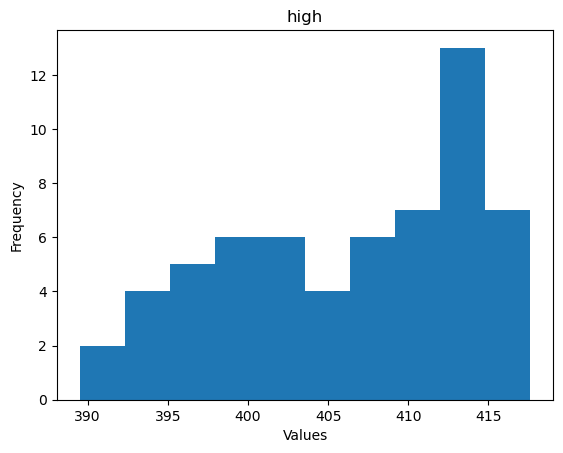

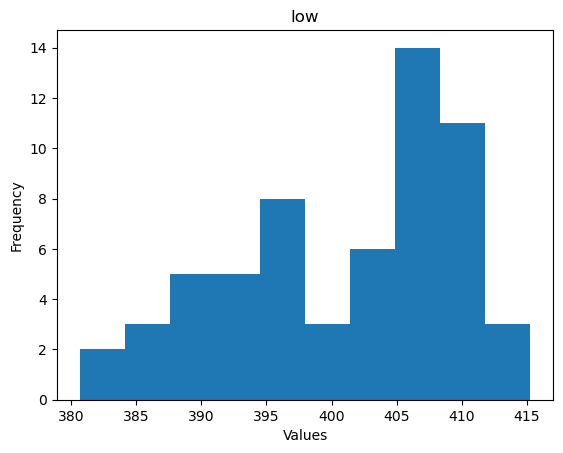

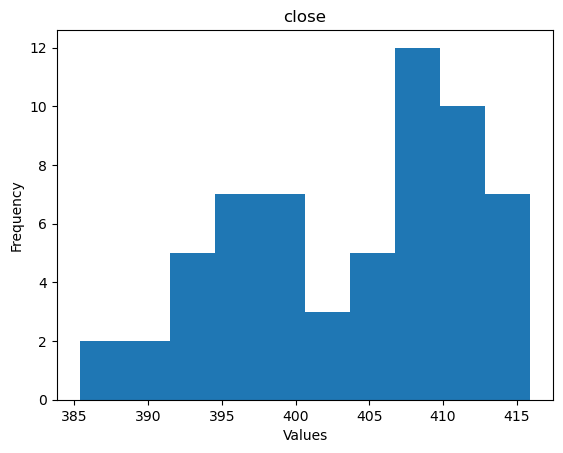

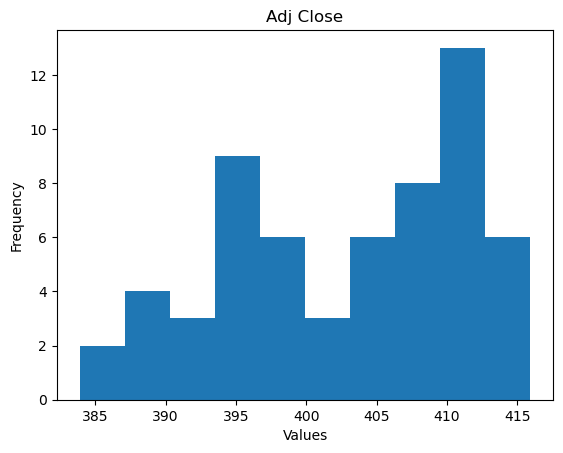

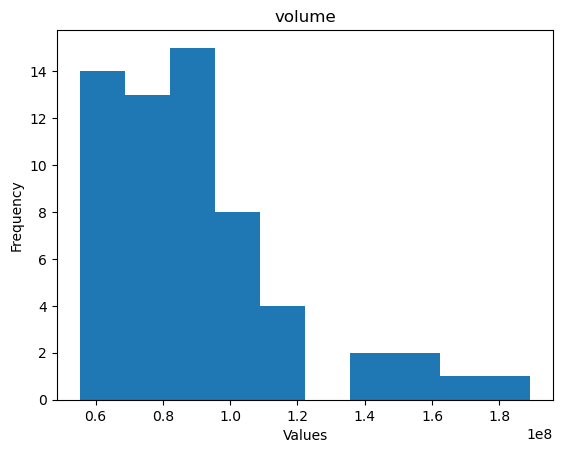

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# create a sample dataframe

df = tmp

# create a histogram for each column
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()


From the above table we can see that the frequency of data is quite unevenly distributed and does not resemble Gaussian distribution, and the data has a quite high standard deviation, which stands for the high volatility of stock price. Hence, the data that we are dealing with is non-stationary

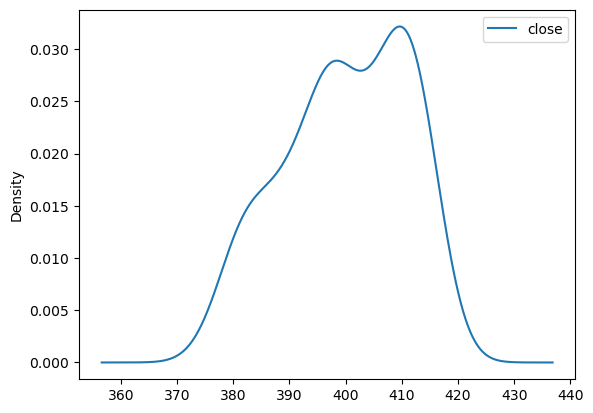

In [8]:
data['close'].plot(kind='kde')

plt.legend()
plt.show()

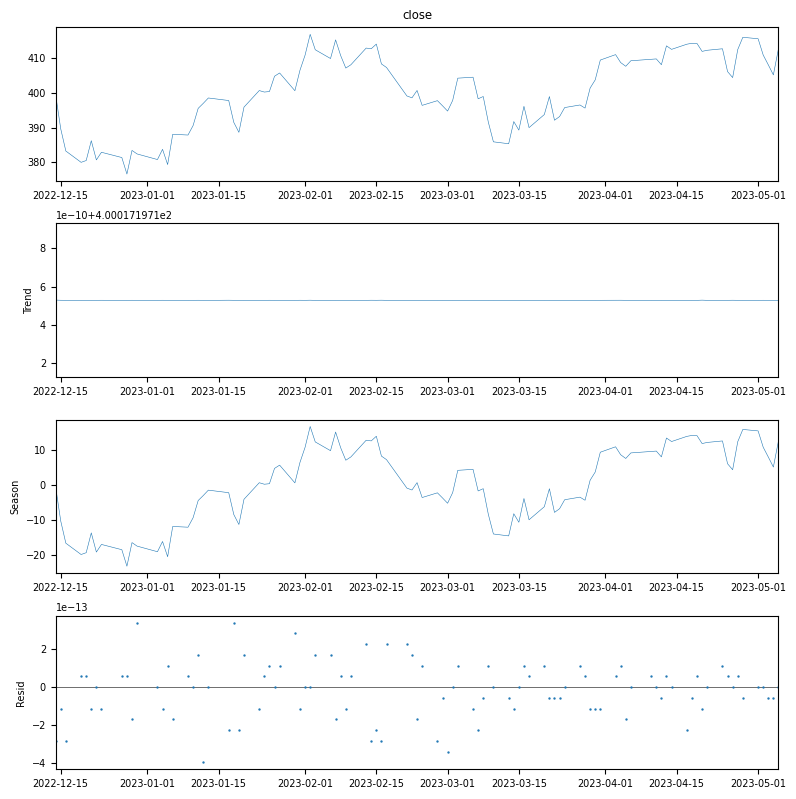

In [9]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.4
mpl.rcParams['lines.markersize'] = 0.7
mpl.rcParams['font.size'] = 7
mpl.rcParams['figure.figsize'] = (8,8)

from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from cycler import cycler


df1 = data
stl = STL(df1['close'], seasonal=13,period = 100)
result = stl.fit()
fig = result.plot()

plt.show()

#### Correlation

Let's explore the correlation between the features of the dataset

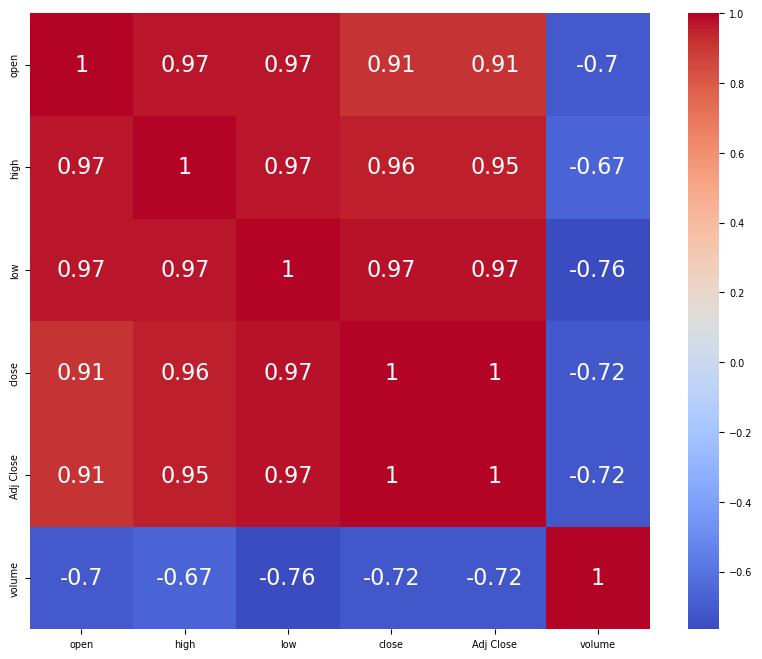

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt

new_df = df.select_dtypes(include='number')
correlMatrix = new_df.corr()

plt.figure(figsize=(10,8))
sb.heatmap(correlMatrix, annot=True, cmap='coolwarm', annot_kws={"size": 16})
plt.show()


We can see from the onfusion matrix that all the values are highly correlated with each other. In contrast, Volume is negatively correlated with other parameters. High correlation between features implies that these features have similar distribution trend or have redundant informationin their data. In this case, it is better to remove one or more of these features without significantly affecting the overall performance of the model. 

# Data Wrangling

### Cleaning Data 

As our data was completely clean and free of empty entries, we had to make it dirty artificially by adding random empty entries. So here is the implementation: 

In [11]:
data.shape
print('Our dataset contain {} records/rows,'
      ' each with {} fields / data attributes'.format(data.shape[0], data.shape[1]))

Our dataset contain 98 records/rows, each with 6 fields / data attributes


In [12]:
data.head(5)
total_nan = np.sum(np.sum(data.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))

Total non-numeric entries: 0


In [13]:
import numpy as np

# Set the number of entries to make dirty
num_entries = 3

# Choose 10 random row indices
random_rows = np.random.randint(0, data.shape[0], size=num_entries)

# Choose 10 random column indices
random_cols = np.random.randint(0, data.shape[1], size=num_entries)

# Add null values to the 10 random entries
data.iloc[random_rows, random_cols] = np.nan

print(data)
total_nan = np.sum(np.sum(data.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))


              open    high     low   close  Adj Close       volume
Date                                                              
2022-12-14  401.61  405.50  396.31  399.40     396.06  108111300.0
2022-12-15     NaN     NaN  387.89  389.63     386.37  117705900.0
2022-12-16  385.18  386.58  381.04  383.27     381.81  119858000.0
2022-12-19  383.47  383.82  378.28  380.02     378.58   79878100.0
2022-12-20  379.23  382.23  377.85  380.54     379.09   74427200.0
...            ...     ...     ...     ...        ...          ...
2023-05-01  415.47  417.62  415.27  415.51     415.51   62122300.0
2023-05-02  414.77  414.82  407.82  410.84     410.84  103998500.0
2023-05-03  411.36  413.87  407.77  408.02     408.02   91531800.0
2023-05-04  406.93  407.27  403.74  405.13     405.13   94901900.0
2023-05-05  408.91  413.72  408.64  412.63     412.63   87776283.0

[98 rows x 6 columns]
Total non-numeric entries: 6


In [14]:
# Remove all rows with null entries
data_clean = data.dropna()

print(data_clean)

              open    high     low   close  Adj Close       volume
Date                                                              
2022-12-14  401.61  405.50  396.31  399.40     396.06  108111300.0
2022-12-16  385.18  386.58  381.04  383.27     381.81  119858000.0
2022-12-19  383.47  383.82  378.28  380.02     378.58   79878100.0
2022-12-20  379.23  382.23  377.85  380.54     379.09   74427200.0
2022-12-21  383.25  387.41  382.69  386.23     384.76   78167400.0
...            ...     ...     ...     ...        ...          ...
2023-05-01  415.47  417.62  415.27  415.51     415.51   62122300.0
2023-05-02  414.77  414.82  407.82  410.84     410.84  103998500.0
2023-05-03  411.36  413.87  407.77  408.02     408.02   91531800.0
2023-05-04  406.93  407.27  403.74  405.13     405.13   94901900.0
2023-05-05  408.91  413.72  408.64  412.63     412.63   87776283.0

[95 rows x 6 columns]


In [15]:
total_nan = np.sum(np.sum(data_clean.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))

Total non-numeric entries: 0


In [16]:
data_clean.shape
print('Our dataset contain {} records/rows,'
      ' each with {} fields / data attributes'.format(data_clean.shape[0], data.shape[1]))

Our dataset contain 95 records/rows, each with 6 fields / data attributes


Now our data is clean again

### Removing Outliers

In [17]:
import pandas as pd

df = data_clean

# calculate the IQR for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# remove outliers from each column
df_clean_outliers = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# display the cleaned dataframe
print(df_clean_outliers)

              open    high     low   close  Adj Close       volume
Date                                                              
2022-12-14  401.61  405.50  396.31  399.40     396.06  108111300.0
2022-12-16  385.18  386.58  381.04  383.27     381.81  119858000.0
2022-12-19  383.47  383.82  378.28  380.02     378.58   79878100.0
2022-12-20  379.23  382.23  377.85  380.54     379.09   74427200.0
2022-12-21  383.25  387.41  382.69  386.23     384.76   78167400.0
...            ...     ...     ...     ...        ...          ...
2023-05-01  415.47  417.62  415.27  415.51     415.51   62122300.0
2023-05-02  414.77  414.82  407.82  410.84     410.84  103998500.0
2023-05-03  411.36  413.87  407.77  408.02     408.02   91531800.0
2023-05-04  406.93  407.27  403.74  405.13     405.13   94901900.0
2023-05-05  408.91  413.72  408.64  412.63     412.63   87776283.0

[89 rows x 6 columns]


In [18]:
total_nan = np.sum(np.sum(df_clean_outliers.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))
df_clean_outliers.shape

Total non-numeric entries: 0


(89, 6)

### Making the data stationary

We learnt that Stock Data is by default non-stationary. We can try to make it stationary, but it has proven to yield less precision because when we flatten the trend we are in some sense loosing the decrease and increase points. So, in our Query machine application we made stationarity optional, up to the client. To do so the client has to pass in `Stationary` variable. In this notebook we will make it `False` just for the sake of demonstration.

In [ ]:
Stationary = False

In [19]:
from statsmodels.tsa.seasonal import STL
import pandas as pd

# Load time series data
df = df_clean_outliers

df_stationary = pd.DataFrame()
# Loop through each column and make it stationary with STL
for col in df.columns:
    # Perform STL decomposition
    result = STL(df[col], seasonal=13, period=100).fit()

    # Obtain detrended data
    detrended_data = df[col] - result.trend
    df_stationary[col] = detrended_data - result.seasonal
    df_stationary.dropna(inplace=True) # Remove NaN values

    # Obtain deseasonalized data
    deseasonal_data = df[col] - result.seasonal
    

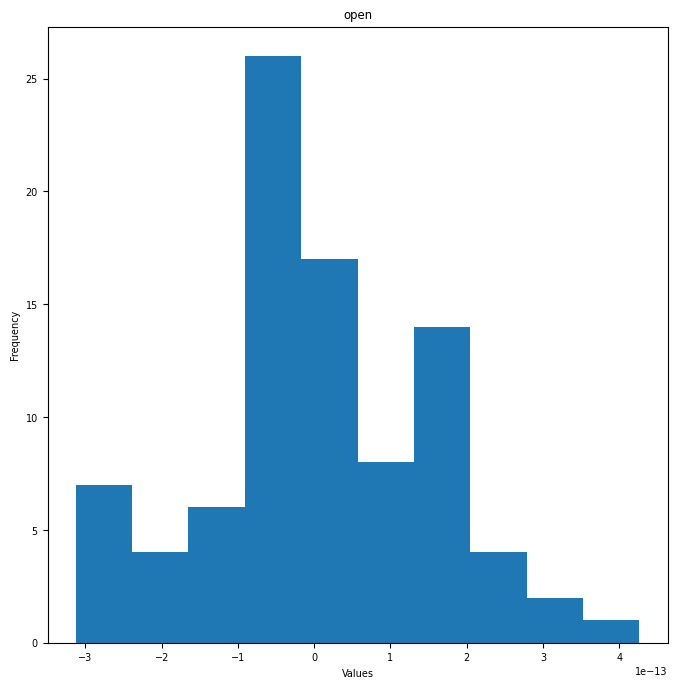

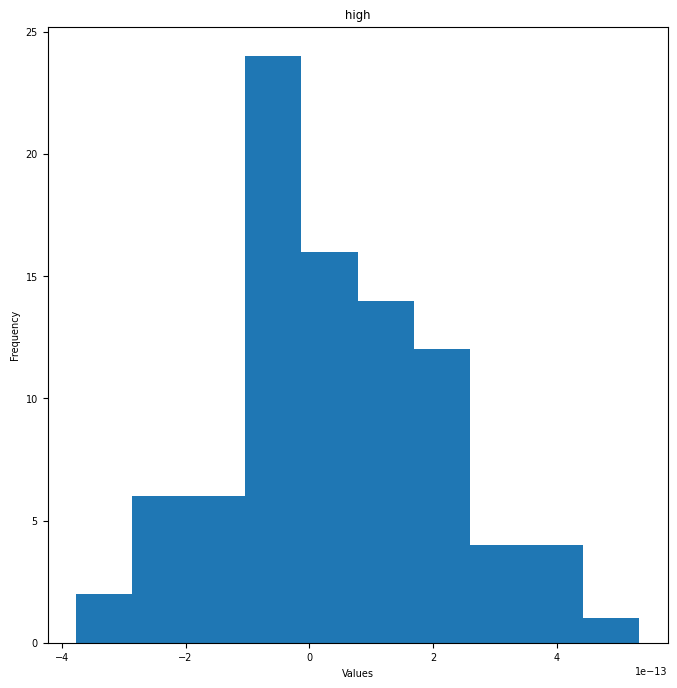

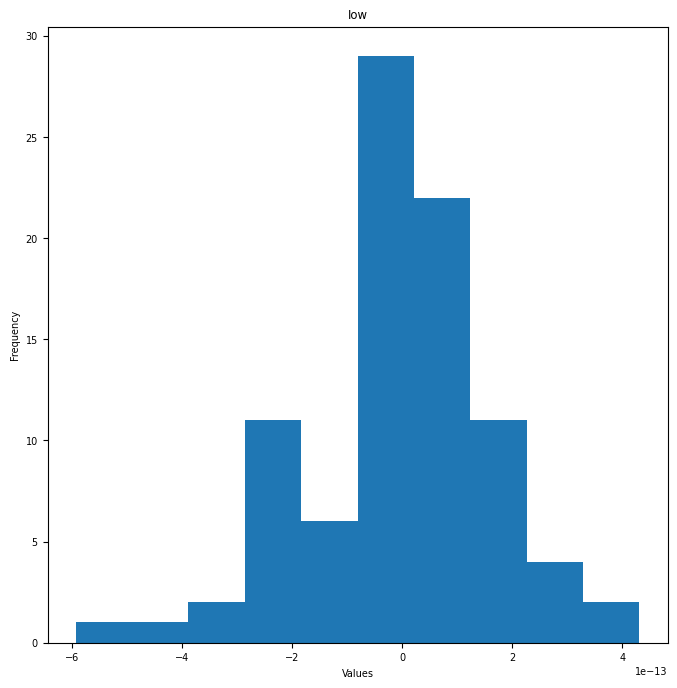

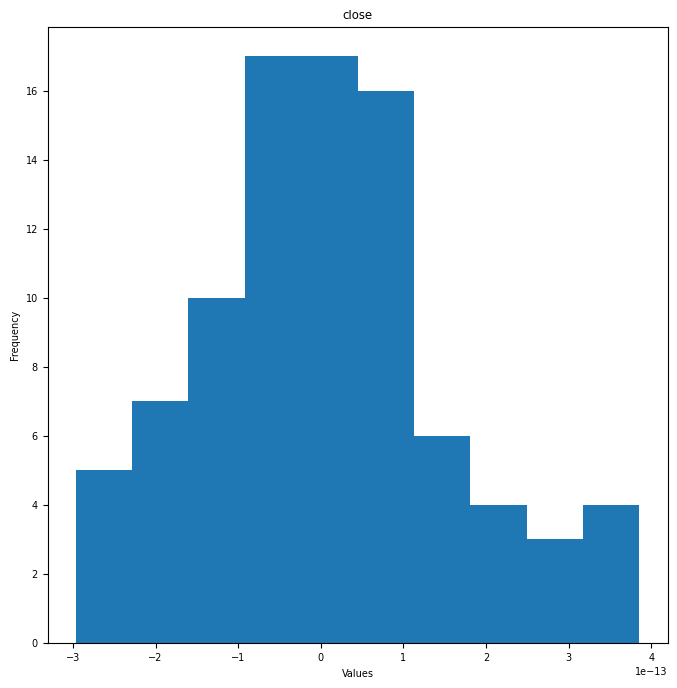

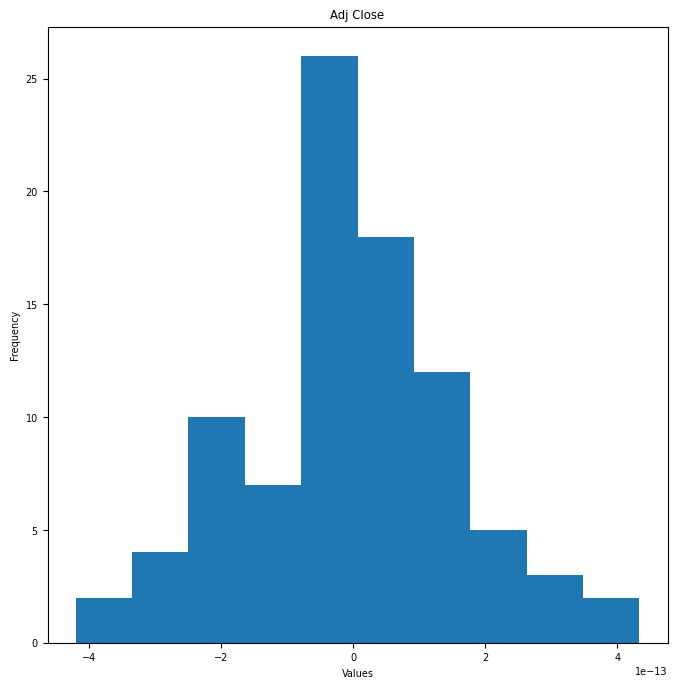

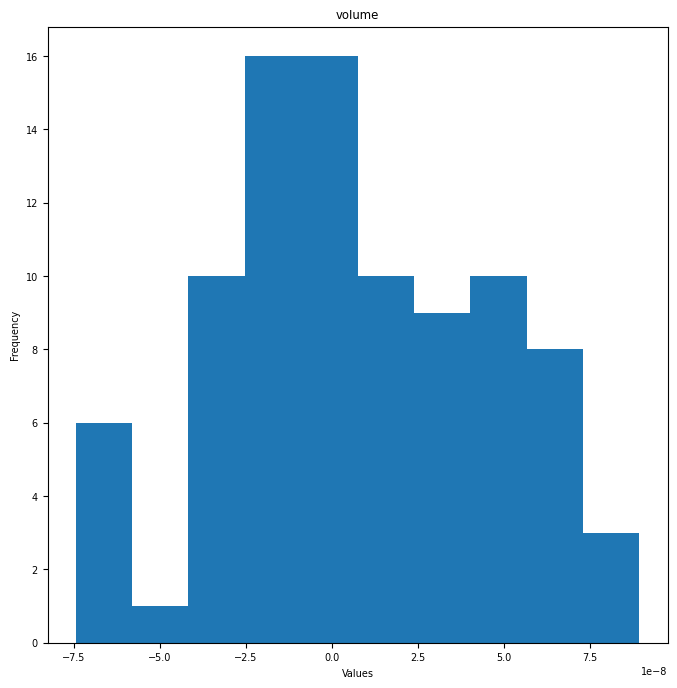

In [20]:
# create a histogram for each column
for col in df_stationary.columns:
    plt.hist(df_stationary[col])
    plt.title(col)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()

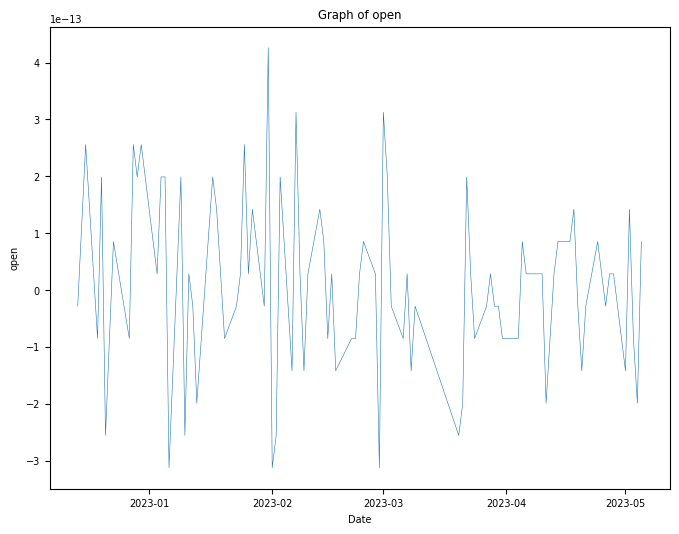

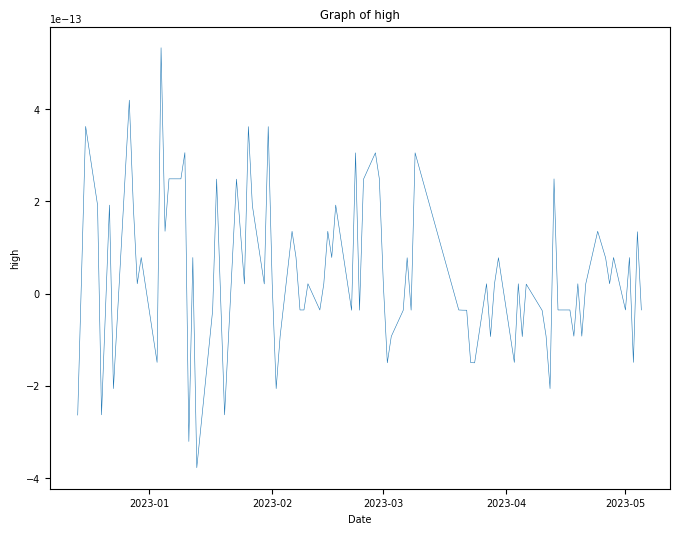

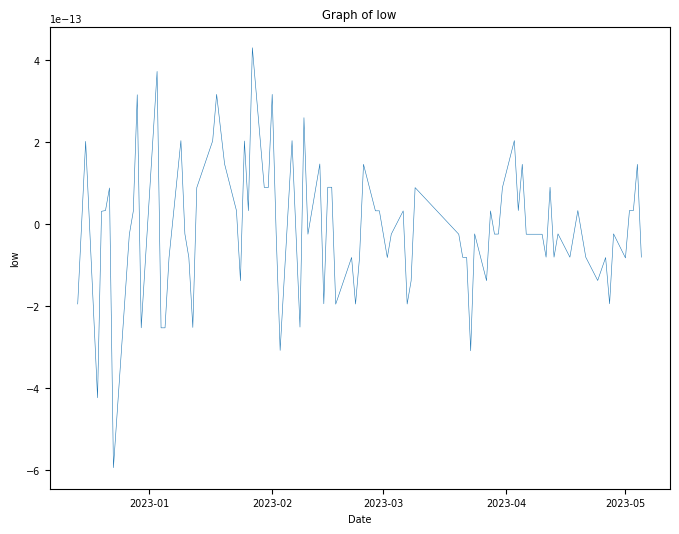

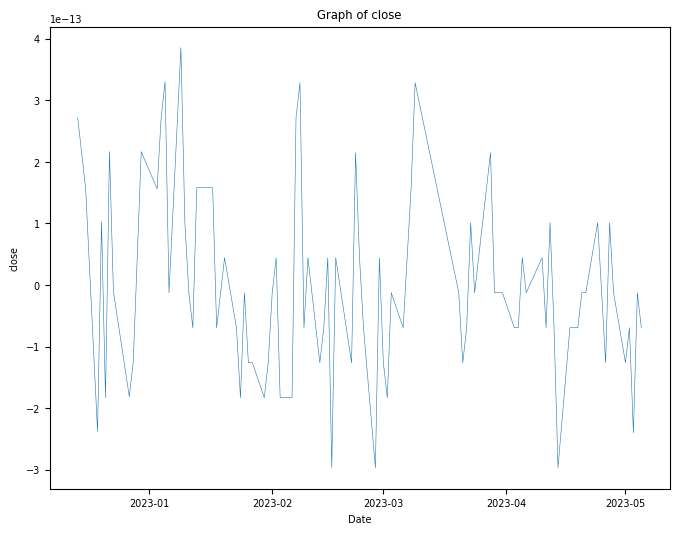

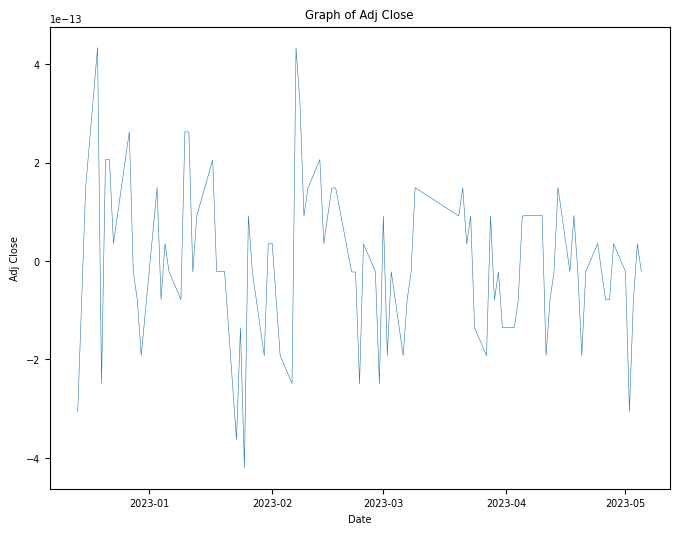

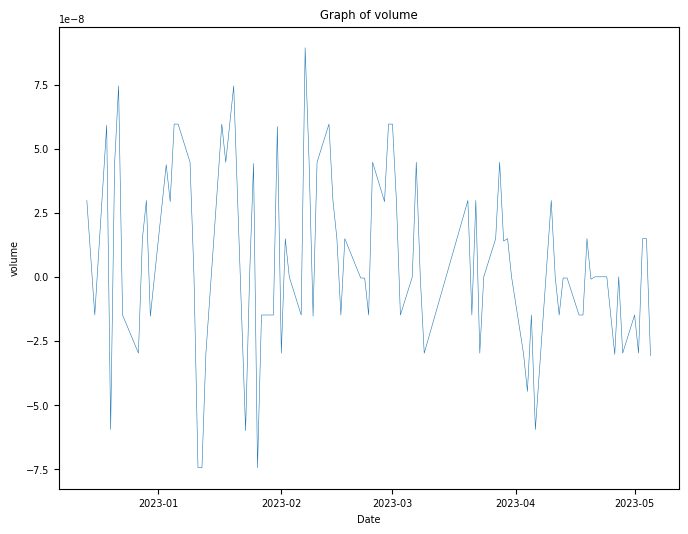

In [21]:
# plot a graph of each column
for col in df_stationary.columns:
    fig, ax = plt.subplots(figsize=(8, 6)) # specify the size of the figure
    ax.plot(df_stationary[col])
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.set_title('Graph of ' + col)
    plt.show()

So, as our Stationarity is False, we return the previous data value to the current variable.

In [ ]:
if Stationary == False: df_stationary = df_clean_outliers

# Feauture Engineering 

#### Smoothening Data

The data we have collected so far is not very smooth, and contains many sudden changes in value over time. This can make it difficult for our model to identify patterns and trends in the data. To make the data smoother and easier to work with, we can apply a technique called exponential smoothing before we calculate any technical indicators.

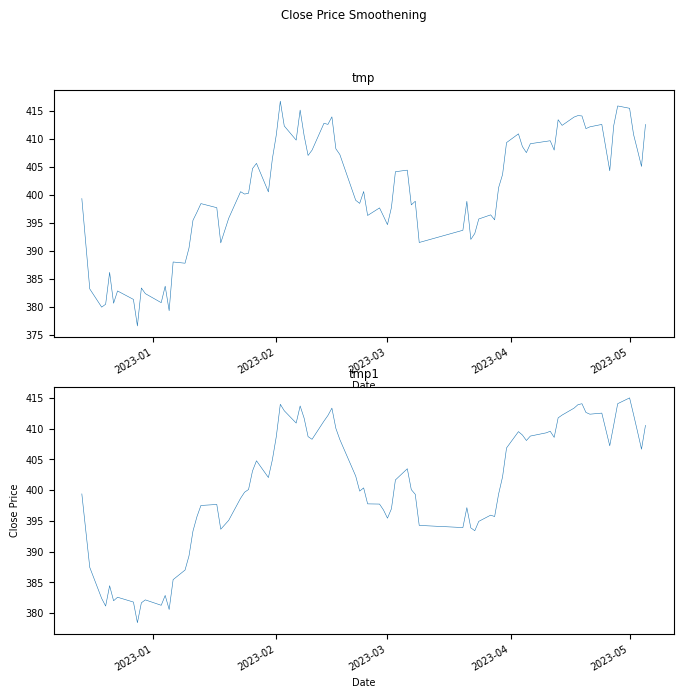

In [22]:

tmp = df_stationary.iloc[:]

def _exponential_smooth(data, alpha):
    
    return data.ewm(alpha=alpha).mean()

data_smooth = _exponential_smooth(df_stationary, 0.65)

tmp1 = data_smooth.iloc[:]

# create a subplot of two plots
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

# plot the first DataFrame in the top subplot
tmp['close'].plot(ax=ax[0])
ax[0].set_title('tmp')

# plot the second DataFrame in the bottom subplot
tmp1['close'].plot(ax=ax[1])
ax[1].set_title('tmp1')

# add axis labels and title
fig.suptitle('Close Price Smoothening')
plt.xlabel('Date')
plt.ylabel('Close Price')

# show the plot
plt.show()

The data has been smoothed to reduce the appearance of spikes and make it easier to approximate and extract trends when computing technical indicators. Peaks and troughs can be problematic and throw off the model.
***************************************************************

In [23]:
total_nan = np.sum(np.sum(df_stationary.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))
df_stationary.shape

Total non-numeric entries: 0


(89, 6)

#### Adding indicators as features

In this step, we use the finta library and the built-in eval function in Python to calculate the technical indicators in the INDICATORS list along with some exponential moving averages (EMA) at different average lengths and a normalized volume value. We remove some columns like 'Open', 'High', 'Low', and 'Adj Close' that apparently have very high correlations with each other and since we can obtain a good enough approximation with our ema's and indicators. We normalize the volume because it has a correlation with price fluctuations.

In [24]:
data = data_smooth

def _get_indicator_data(data):

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)
data

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2022-12-14,399.400000,NaN,0.000000,0.000000,NaN,-3.540969e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2022-12-16,387.451852,0.000000,-0.268067,-0.148926,NaN,-6.387078e+07,NaN,NaN,NaN,NaN,-1.168126e+08,-66.666667,NaN,NaN,NaN,0.984963,0.985163,0.985331,0.986177,1.035045
2022-12-19,382.404754,0.000000,-0.498081,-0.292023,NaN,-9.379140e+07,NaN,NaN,NaN,NaN,-2.085423e+08,-74.868431,NaN,NaN,NaN,0.981431,0.981810,0.982128,0.983709,0.877803
2022-12-20,381.174198,0.000000,-0.634918,-0.408180,NaN,-9.359967e+07,NaN,NaN,NaN,NaN,-2.888540e+08,-75.916279,NaN,NaN,NaN,0.983776,0.984276,0.984693,0.986724,0.830412
2022-12-21,384.477820,17.989205,-0.564448,-0.454666,NaN,-6.804689e+07,NaN,NaN,NaN,NaN,-2.099435e+08,-40.558624,NaN,NaN,NaN,0.993894,0.994373,0.994766,0.996587,0.860038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,415.003312,63.451053,2.728949,2.771028,85.502394,9.736652e+08,3.928606,2.788060,71.386149,1.570530,7.565897e+08,134.665906,0.029104,0.823240,1.113525,1.028187,1.020325,1.016070,1.007690,0.943224
2023-05-02,412.297159,56.853102,2.579097,2.732642,59.379163,9.644681e+08,4.135938,-1.039179,63.513082,0.130279,6.640165e+08,53.343968,0.014133,0.868425,1.012580,1.020957,1.013031,1.008807,1.000932,1.179720
2023-05-03,409.517006,50.987229,2.210773,2.628268,32.541585,9.051776e+08,4.272111,-4.387213,62.649248,-0.654572,5.721202e+08,-6.908639,0.007524,0.906010,0.995444,1.013732,1.005911,1.001871,0.995148,1.138625


In [25]:
data.shape
print('Our dataset contain {} records/rows,'
      ' each with {} fields / data attributes'.format(data.shape[0], data.shape[1]))

Our dataset contain 89 records/rows, each with 20 fields / data attributes


In [26]:
total_nan = np.sum(np.sum(data.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))

Total non-numeric entries: 106


In [27]:
total_nan = np.sum(np.sum(data.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))
data.shape

Total non-numeric entries: 106


(89, 20)

#### Introducing Truth Values

Calculating truth values is one of the most crucial steps in this project, as it is essential for training a machine learning model to make predictions. To obtain these truth values, we need to look into the future and observe the stock prices to determine whether we should buy or sell. Fortunately, we can use historical data to accomplish this.

To determine whether to buy (1) or sell (0) on a specific day, we can refer to the table where we initially retrieved our data. For instance, if we want to make a decision on the day of 1993-03-29, where the closing price was 11.4375, we need to look ahead X number of days to determine whether the price has increased or decreased relative to the closing price of 1993-03-29. If we look one day ahead and see that the price has increased to 11.5, the truth value on 1993-03-29 would be a buy (1).

Finally, as this is also the last step of data processing, we remove any NaN values generated by our indicators and predictions, as well as the 'close' column.

This function is used to produce 'truth' values for a machine learning model that predicts stock price movements. Specifically, it looks 'window' rows ahead to see if the price increased (1) or decreased (0), and creates a binary 'pred' column in the DataFrame 'data' with 1s and 0s indicating whether the price went up or down in the 'window' period.

Here's a breakdown of the creating truth values:

- The function takes two arguments: the DataFrame 'data', and the number of days (or rows) 'window' to look ahead to see what the price did.
- Inside the function, the 'shift' method is used to create a copy of the 'close' column that is shifted up by 'window' rows. This represents the 'future' price at that row.
- A boolean Series is created by comparing the shifted 'close' column with the original 'close' column. If the future price is greater than or equal to the current price, the value is True (1), otherwise False (0).
- The resulting Series is sliced to exclude the last 'window' rows, which contain NaN values due to the shift operation.
- The resulting boolean values are converted to integers (1s and 0s) and stored in a new 'pred' column in the DataFrame 'data'.
- Finally, the 'data' DataFrame is returned with the 'pred' column added.

After this function is called, the 'close' column is deleted from the DataFrame to prevent data leakage, and any rows containing NaN values are dropped using the 'dropna' method.

The resulting DataFrame 'data' is then ready to be used for training a machine learning model to predict stock price movements.

In [28]:
def _produce_prediction(data, window):
   
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
   
    return data
window = 15
live_pred_data = data.iloc[-window:]
data_with_pred = _produce_prediction(data, window)
data_with_pred
total_nan = np.sum(np.sum(data_with_pred.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))
data_with_pred


Total non-numeric entries: 121


,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-14,399.400000,NaN,0.000000,0.000000,NaN,-3.540969e+07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
2022-12-16,387.451852,0.000000,-0.268067,-0.148926,NaN,-6.387078e+07,NaN,NaN,NaN,NaN,...,-66.666667,NaN,NaN,NaN,0.984963,0.985163,0.985331,0.986177,1.035045,1.0
2022-12-19,382.404754,0.000000,-0.498081,-0.292023,NaN,-9.379140e+07,NaN,NaN,NaN,NaN,...,-74.868431,NaN,NaN,NaN,0.981431,0.981810,0.982128,0.983709,0.877803,1.0
2022-12-20,381.174198,0.000000,-0.634918,-0.408180,NaN,-9.359967e+07,NaN,NaN,NaN,NaN,...,-75.916279,NaN,NaN,NaN,0.983776,0.984276,0.984693,0.986724,0.830412,1.0
2022-12-21,384.477820,17.989205,-0.564448,-0.454666,NaN,-6.804689e+07,NaN,NaN,NaN,NaN,...,-40.558624,NaN,NaN,NaN,0.993894,0.994373,0.994766,0.996587,0.860038,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,415.003312,63.451053,2.728949,2.771028,85.502394,9.736652e+08,3.928606,2.788060,71.386149,1.570530,...,134.665906,0.029104,0.823240,1.113525,1.028187,1.020325,1.016070,1.007690,0.943224,NaN
2023-05-02,412.297159,56.853102,2.579097,2.732642,59.379163,9.644681e+08,4.135938,-1.039179,63.513082,0.130279,...,53.343968,0.014133,0.868425,1.012580,1.020957,1.013031,1.008807,1.000932,1.179720,NaN
2023-05-03,409.517006,50.987229,2.210773,2.628268,32.541585,9.051776e+08,4.272111,-4.387213,62.649248,-0.654572,...,-6.908639,0.007524,0.906010,0.995444,1.013732,1.005911,1.001871,0.995148,1.138625,NaN


In [29]:
del (data['close'])
data_with_pred = data_with_pred.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
del(live_pred_data['close'])

In [30]:
total_nan = np.sum(np.sum(data_with_pred.isnull()))

print('Total non-numeric entries: {}'.format(total_nan))
data_with_pred.shape

Total non-numeric entries: 0


(60, 20)

#### Analyzing Features Correlation

As we now have an array of new features, it is of high importance to check the correlation between them and avoid potential redundancy and multi-collinearity in the data.

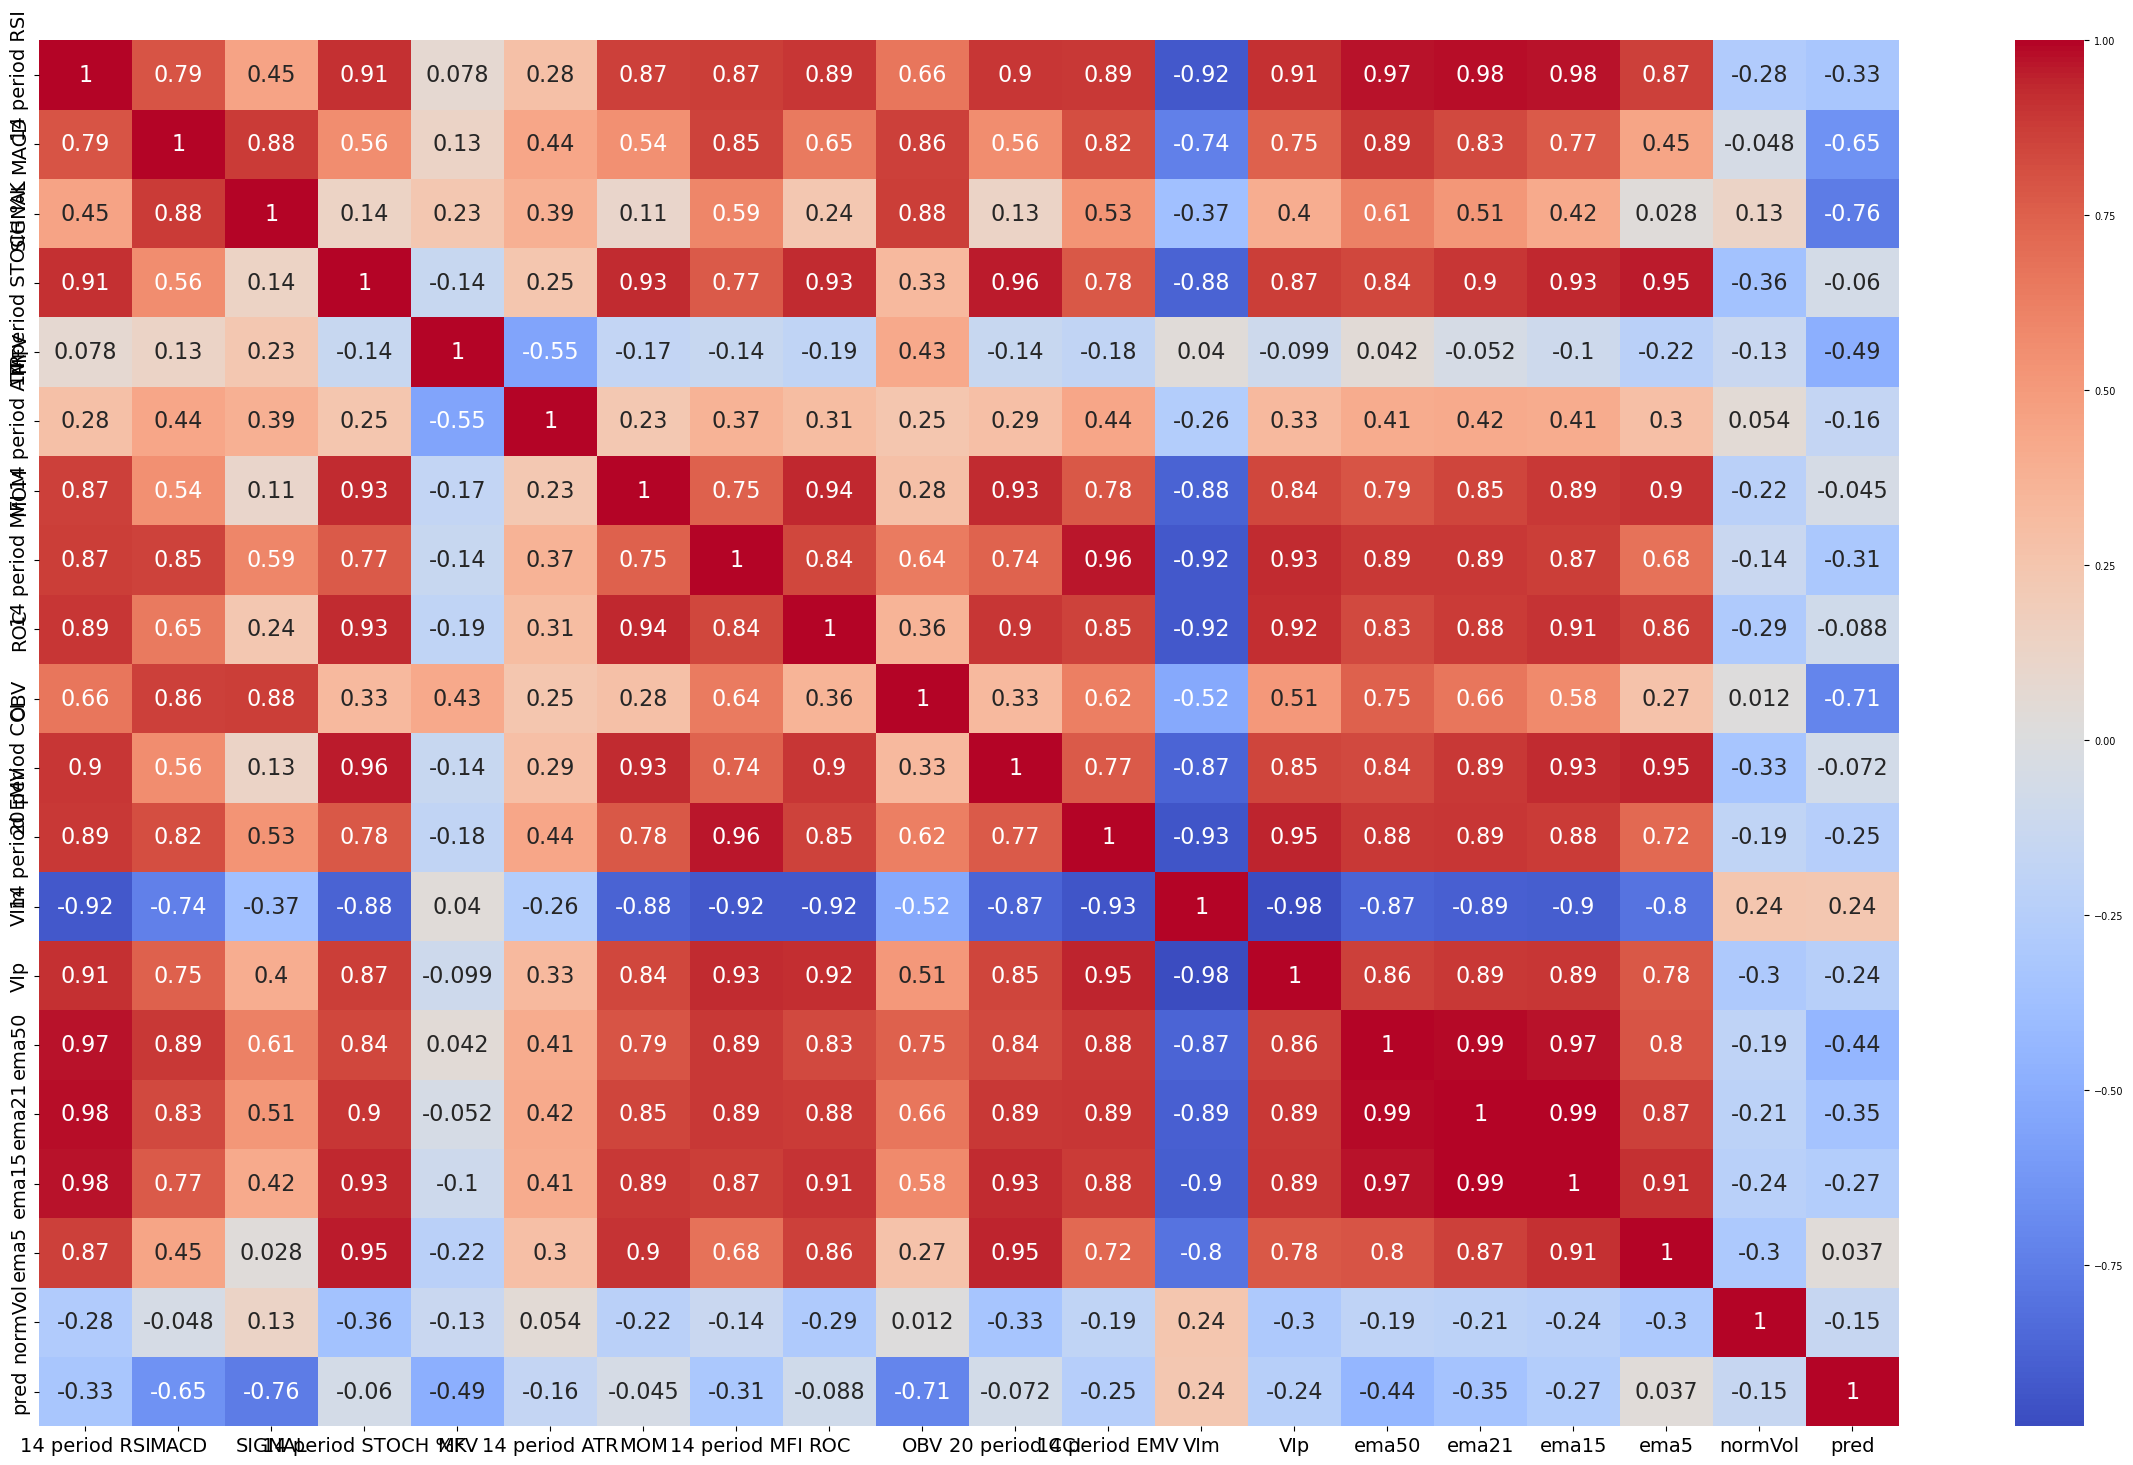

In [31]:
import seaborn as sb
import matplotlib.pyplot as plt

new_df = data_with_pred.select_dtypes(include='number')
correlMatrix = new_df.corr()

# Set figure size
plt.figure(figsize=(30, 18))

# Plot heatmap
heatmap = sb.heatmap(correlMatrix, annot=True, cmap='coolwarm', annot_kws={"size": 16})

# Set font size of axis labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)

# Display plot
plt.show()


Almost all features except `Vlm - volume` and `ATR - Average True Range` have negative correlation with the target feature, this suggests that these features may be a crucial predictor of the target variable. However, it is important to note that correlation alone is not enough to determine the importance of a feature.

It is possible that some of the negatively correlated features may be redundant or highly correlated with other features. In such cases, removing these features will simplify the model and improve its performance. On the other hand, some of the negatively correlated features may still be important predictors of the target variable, even though they have an inverse relationship with it. So, we decided to give the benefit of the doubt and leave all the features as they are

In [32]:
data =  data_with_pred

**************************************************

# Query Answering Machine

### 4. Model Creation
Before training our model, we need to divide our data into a training set and a testing set. However, because we are dealing with time-series data, we must be cautious in how we do this. If we split the data randomly, we may introduce a look-ahead bias, which can lead to inaccurate predictions in the stock market. This bias arises when the model is trained on data that it has already seen.

To prevent this we are going to be training the model using a different technique - cross-validation.

First, we’re going to use multiple classifiers to create an ensemble model. The goal here is to combine the predictions of several models to try and improve on predictability. For each sub-model, we’re also going to use a feature from Sklearn, GridSearchCV, to optimize each model for the best possible results.

We can use global variables to store the best model, best precision and average precision of each model

In [33]:
Average_global_model = 0
Best_global_model = 0
Global_precision = 0

In [34]:
data.shape

(60, 20)

 But how can we choose our models for this project? 

We've seen in Data exploration section that Stock prices are volatile, and its features are well correalted. And there are quite a bit of outliers that are caused by unexpected jumps or crushes in stock. Based on these characteristics of the dataset and the characteristics of the classifiers, we will choose models.

### Itertation 1: KNN

#### Solution and Justification 

Using the K-Nearest Neighbors (KNN) model to generate a stock price predictor ML model can be effective in some cases, one advantage of the KNN model is that it can handle non-linear relationships and can be effective in predicting outcomes for non-stationary data for our stock prices. KNN can also handle outliers and can be used with different distance metrics to capture the similarities and differences between data points.

Also, since the KNN algorithm has a flair for predicting the values of unknown entities, it's useful in predicting the future value of stocks based on historical data.


#### Solution Details


This code trains a K-nearest neighbors classifier on input data and tests it on a separate test set. The best model is selected using grid search with cross-validation, and the confusion matrix of the predictions is plotted. The best estimator/trained model is returned.

In [35]:
def precisionSMP(values, prediction):
    good = 0
    total = 0
    if(np.sum(prediction) == 0):
        return 0
    for it in range(len(values)):
        if prediction[it] == 1 and values[it]==1:
                good+=1
    return good/np.sum(prediction)

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    #print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)
    
    #cm = confusion_matrix(y_test, prediction)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.title("Confusion Matrix")
    #plt.show()

    #print(classification_report(y_test, prediction))
    #print(confusion_matrix(y_test, prediction))
    
    return knn_best
    

This code trains a K-Nearest Neighbors (KNN) classifier on the input data. 

The function `_train_KNN` takes four arguments: `X_train`, `y_train`, `X_test`, and `y_test`, which are the training and testing feature matrices and target vectors, respectively. 

The function starts by initializing a `KNeighborsClassifier` object and creating a dictionary `params_knn` that contains a range of values for the hyperparameter `n_neighbors`. The function then uses `GridSearchCV` to perform a grid search over the hyperparameter space, using 5-fold cross-validation to determine the best value of `n_neighbors`. The best model is saved as `knn_best`. 

The function then uses the trained `knn_best` to make predictions on the testing data `X_test`, and returns `knn_best`.

The code includes commented-out lines that generate and display a confusion matrix and classification report for the model, which can be useful for evaluating the model's performance on the test data.

This code performs cross-validation on a given dataset using the K-Nearest Neighbors (KNN) classification model. It partitions the data into equal chunks of length len_train at intervals of num_train days, trains the KNN model on the training set, evaluates its precision on the test set, and stores the results in a list. Finally, it prints the average precision score for the KNN model across all partitions.

In [37]:
def cross_Validation_KNN(data):
   
    num_train = 5 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 50 # Length of each train-test set
    
    # Lists to store the results from each model
    knn_RESULTS = []
    
    i = 0
    printer = 0
    Best_KNN_Model = 0
    Best_precision = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        
        if len(df) < 25:
            break
        
        print(i * num_train, (i * num_train) + len_train)
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)

        knn_model = _train_KNN(X_train, y_train, X_test, y_test)

        knn_prediction = knn_model.predict(X_test)
        
        knn_precision = precisionSMP(y_test.values, knn_prediction)
        if Best_precision < knn_precision: 
            Best_KNN_Model = knn_model 
            Best_precision = knn_precision
        
        if (printer%10 == 0):
            print(i * num_train, (i * num_train) + len_train)
            #print('knn prediction is ', knn_prediction)
            #print('truth values are ', y_test.values)
            #print(knn_precision)
        knn_RESULTS.append(knn_precision)
        printer = printer + 1
    
    Average_KNN = sum(knn_RESULTS) / len(knn_RESULTS)
    print('KNN precision = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print("The Best KNN Model has precision = ", Best_precision)
    return Average_KNN, Best_KNN_Model, Best_precision

Average_KNN, Best_KNN_Model, Best_KNN_precision = cross_Validation_KNN(data) 


if Average_global_model < Average_KNN:
    Average_global_model = Average_KNN
    Best_global_model = Best_KNN_Model
    Global_precision = Best_KNN_precision
    print("The Best KNN Model So Far has precision: ", Best_KNN_precision)
print("The Best Global Model So Far has precision: ", Global_precision)

5 55
5 55
10 60
15 65
20 70
25 75
30 80
35 85
40 90
KNN precision = 0.8022970085470085
The Best KNN Model has precision =  1.0
The Best KNN Model So Far has precision:  1.0
The Best Global Model So Far has precision:  1.0


#### Lessons Learnt

We received quite a high precision of 80%, which is impressive. But knowing the drawbacks of this model such as in high-dimensional spaces, the k-NN algorithm faces two difficulties: It becomes computationally more expensive to compute distance and find the nearest neighbors in high-dimensional space. Our assumption of similar points being situated closely breaks. We can assume the integration of GridSearch for finding the most optimal KNN model helped a lot. But let's look at other potential models to increase precision.

### Iteration 2: SVM

#### Solution and Justification 

Next, we can think of SVM. Generally, SVM has a higher precision value than KNN. And also, SVM has processing time faster than KNN.

Based on size and complexity of the dataset we have, it is suitable to use SVMs on a stock price analyzer project because SVMs work well with medium-sized datasets with high-dimensional features. Our stock price data includes a large number of features, such as '14 period RSI', 'MACD', 'SIGNAL', and 'ema21' prices, as well as normalized volume and market averaging price data, which can create a high-dimensional feature space.

Furthermore, SVMs are known for their ability to handle non-linearly separable data, which is often the case with stock price data. SVMs can also handle noisy data, which is a common characteristic of financial data. That's why we decided to apply SVM on our project.
 

#### Solution Details


We train a hyper-dimentional Support Vector Machine (SVM) model with Kernel using the sklearn library, with hyperparameters tuning using grid search. Then we use the best model to predict on a test set and evaluate the performance using a confusion matrix plot, and return the trained model.

In [38]:
from sklearn.svm import SVC

def train_svm(X_train, y_train, X_test, y_test):
    svm = SVC()
    # Create a dictionary of all values we want to test for C and gamma
    params_svm = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto']}
    
    # Use gridsearch to test all values for C and gamma
    svm_gs = GridSearchCV(svm, params_svm, cv=5)
    
    # Fit model to training data
    svm_gs.fit(X_train, y_train)
    
    # Save best model
    svm_best = svm_gs.best_estimator_
     
    # Check best C and gamma values
    #print(svm_gs.best_params_)
    
    prediction = svm_best.predict(X_test)
    
    #cm = confusion_matrix(y_test, prediction)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.title("Confusion Matrix")
    #plt.show()

    #print(classification_report(y_test, prediction))
    #print(confusion_matrix(y_test, prediction))
    
    return svm_best

The function `train_svm` takes in four parameters: `X_train`, `y_train`, `X_test`, and `y_test`, which are the training and test sets of features and labels, respectively. 

The function first creates an SVM object and specifies a dictionary of parameter combinations to be tested in a grid search. Specifically, the `params_svm` dictionary contains values of the regularization parameter `C` and kernel coefficient `gamma` to be tested. The `GridSearchCV` class is used to perform a grid search with 5-fold cross-validation to find the best combination of `C` and `gamma`. The `svm_best` object is then set to be the best estimator of the SVM model obtained from the grid search. 

Finally, the function uses the `svm_best` object to make predictions on the test set. The predicted labels are stored in the `prediction` variable and returned by the function. 

This implementation of SVM is chosen because it is a widely-used and effective machine learning algorithm for classification problems, particularly when the number of features is relatively small compared to the number of training examples. Grid search is used to find the optimal combination of `C` and `gamma` parameters for the SVM model. This helps to ensure that the model is well-tuned and can achieve the best possible performance on the test data.

Now, we use this code to perform cross-validation on a dataset by partitioning it into equal parts of size len_train and then evaluating the precision of an SVM model that is trained on each partition. We store the results in a list and then print out the average precision across all the partitions.


In [39]:
def cross_Validation_SVM(data):


    
    num_train = 5 
    len_train = 50 
    
    
    svm_RESULTS = []
    
    i = 0
    printer = 0
    Best_SVM_Model = 0
    Best_precision = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        
        if len(df) < 25:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        try:
            svm_model = train_svm(X_train, y_train, X_test, y_test)

            svm_prediction = svm_model.predict(X_test)

            svm_precision = precisionSMP(y_test.values, svm_prediction)
        except:
            y_train[0] = 1 - y_train[0]
            svm_model = train_svm(X_train, y_train, X_test, y_test)
            svm_prediction = svm_model.predict(X_test)
            svm_precision = precision_score(y_test.values, svm_prediction)
        if Best_precision < svm_precision: 
            Best_SVM_Model = svm_model
            Best_precision = svm_precision
        
        if (printer%10 == 0):
            #print(i * num_train, (i * num_train) + len_train)
            #print('svm prediction is ', svm_prediction)
            #print('truth values are ', y_test.values)
            print(svm_precision)
        svm_RESULTS.append(svm_precision)
        printer = printer + 1
    Average_SVM =  sum(svm_RESULTS) / len(svm_RESULTS)
    print('Average SVM precision = ' + str( sum(svm_RESULTS) / len(svm_RESULTS)))
    print("The Best SVM Model has precision: ", Best_precision)
    return  Average_SVM, Best_SVM_Model, Best_precision

Average_SVM, Best_SVM_Model, Best_SVM_precision = cross_Validation_SVM(data)


if Average_global_model < Average_SVM:
    Average_global_model = Average_SVM
    Best_global_model = Best_SVM_Model
    Global_precision = Best_SVM_precision
    print("The Best SVM Model So Far has precision: ", Best_SVM_precision)
print("The Best Global Model So Far has precision: ", Global_precision)

1.0
Average SVM precision = 0.8198412698412699
The Best SVM Model has precision:  1.0
The Best SVM Model So Far has precision:  1.0
The Best Global Model So Far has precision:  1.0


#### Lessons Learnt

We received quite a better precision of 81.9% that is most likely related to suitability of the Support Vector Machine model with hyperdimentional features and mid-sized dataset, in our case 100 days of stock data. So far this is our best model and we store it globally. We believe we can do better using larger data of around 200 to 1000 days ofstock price details.

### Iteration 3: Random Forest

#### Solution and Justification 

Next, ss the stock data has lots of noise, it is better to use the classifier that is able to handle the high number of explanatory variables. The Random Forest Classifier is the one. Additionally, Random Forest generally has in average 96% prediction precision, making it the most suitable of all three models. However, each of these models have their advantages and drawbacks. Random Forest Classifier works the best with large datasets. But we will how it will perform with 100 days of stock data.

#### Solution Details


we use grid search to test different values for the number of estimators, fit the model to the training data, save the best model, make a prediction on the test set, create a confusion matrix and display it using matplotlib, and return the best model.

In [40]:
def train_rf(X_train, y_train, X_test, y_test):

    rf = RandomForestClassifier()
    
    params_rf = {'n_estimators': [25,110,130,140,150,160,180,200,700]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    #print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)
    
    #cm = confusion_matrix(y_test, prediction)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.title("Confusion Matrix")
    #plt.show()

    #print(classification_report(y_test, prediction))
    #print(confusion_matrix(y_test, prediction))
    
    return rf_best

This code trains a random forest classifier using the given training data `X_train` and `y_train`. The function also takes in test data `X_test` and `y_test` which is used to evaluate the performance of the model after training.

The random forest classifier is initialized with default parameters. A dictionary of hyperparameters `params_rf` is defined which includes different values for the `n_estimators` parameter. 

GridSearchCV is used to perform a cross-validation search over the hyperparameters defined in `params_rf`. The `cv` parameter sets the number of folds used in cross-validation. In this case, a 5-fold cross-validation is used.

The `fit` method is used to train the random forest classifier on the training data. Once the best estimator is obtained using GridSearchCV, it is used to make predictions on the test data `X_test`. 

Finally, the function returns the best estimator found using GridSearchCV.

This approach is chosen to optimize the hyperparameters of the model to improve its performance. In this case, `n_estimators` is chosen as the hyperparameter to be optimized using a range of values. By performing a grid search over the hyperparameters, the function returns the best estimator found during the cross-validation process.

The parameters used in the grid search are chosen based on domain knowledge, previous research, and experimentation. In this case, the range of `n_estimators` values is selected based on empirical evidence that they can improve model performance.

Now, we use this code to perform cross-validation on a dataset by partitioning it into equal parts of size len_train and then evaluating the precision of an RF model that is trained on each partition. We store the results in a list and then print out the average precision across all the partitions.

In [42]:
def cross_Validation_RF(data):


    
    num_train = 5 
    len_train = 50 
    
    # Lists to store the results from each model
    rf_RESULTS = []
    
    i = 0
    printer = 0
    Best_RF_Model = 0
    Best_precision = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        
        if len(df) < 25:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        rf_model = train_rf(X_train, y_train, X_test, y_test)

        rf_prediction = rf_model.predict(X_test)

        rf_precision = precisionSMP(y_test.values, rf_prediction)
        if Best_precision < rf_precision: 
            Best_RF_Model = rf_model
            Best_precision = rf_precision
        
        if (printer%10 == 0):
            #print(i * num_train, (i * num_train) + len_train)
            #print('svm prediction is ', rf_prediction)
            #print('truth values are ', y_test.values)
            print(rf_precision)
        rf_RESULTS.append(rf_precision)
        printer = printer + 1
    Average_RF =  sum(rf_RESULTS) / len(rf_RESULTS)
    print('Average RF precision = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print("The Best Random Forest Model has precision: ", Best_precision)
    return Average_RF, Best_RF_Model,  Best_precision

Average_RF, Best_RF_Model, Best_RF_precision = cross_Validation_RF(data)

if Average_global_model < Average_RF:
    Average_global_model = Average_RF
    Best_global_model = Best_RF_Model
    Global_precision = Best_RF_precision
    print("The Best RF Model So Far has precision: ", Best_RF_precision)
print("The Best Global Model So Far has precision: ", Global_precision)

1.0
Average RF precision = 0.8224206349206348
The Best Random Forest Model has precision:  1.0
The Best RF Model So Far has precision:  1.0
The Best Global Model So Far has precision:  1.0


#### Lessons Learnt

The output shows that the average precision obtained from the cross-validation is 82%, this is the best model so far.
The analysis suggests that the RF model performs reasonably well on the dataset, and the cross-validation procedure helps to ensure that the obtained precision is not due to chance. Next we can try to boost our SVM model using Boost Classifier and try to maximize the precision. We learnt that Random Forest is the complex model that runs for a long time, boosting it wouldn't make sense. 

### Iteration 4: AdaBOOST 

#### Solution and Justification 

Now to strengthen our model we can take the best of each model and combine them using AdaBoost Classifier

Using an AdaBoost Classifier that combines the predictions of Support Vector Machines (SVM) and new Decision Tree model as estimators/features to generate a stock price predictor ML model can be effective for several reasons:

* Ensemble Learning: The AdaBoost Classifier is an example of an ensemble learning method, which combines the predictions of multiple models to improve the overall predictive precision. This approach can help to mitigate the weaknesses of any individual model and capture a more comprehensive picture of the data.

* Combination of models: By combining the predictions of SVM and Decision Tree, the AdaBoost Classifier is leveraging the strengths of each individual model. For example, SVM can handle high-dimensional data, and Decision Tree can handle noisy data. By using both models, the AdaBoost Classifier is better able to capture the complex relationships present in the stock price dataset.

* Robustness: The combination of multiple models makes the AdaBoost Classifier more robust to outliers and noise in the data. Outliers and noise can have a significant impact on the predictions of individual models, but by combining multiple models, the AdaBoost Classifier can help to smooth out these effects and produce more accurate predictions.

#### Solution Details


First we train our Decision Tree in a similar way as the other models. We choose a wide range of values for `max_depth` parameter to avoid overfitting and underfitting, also medium range of values for `min_samples_split` to have a balanced branching.  

In [41]:
def train_dt(X_train, y_train, X_test, y_test):

    
    
    dt = tree.DecisionTreeClassifier()
    
    
    params_grid = {'max_depth':[3,4,5,7,10], 'min_samples_split':[3,5,7]}
    
    # Use gridsearch to test all values for n_estimators
    dt_gs = GridSearchCV(dt, params_grid, cv=5)
    
    # Fit model to training data
    dt_gs.fit(X_train, y_train)
    
    # Save best model
    dt_best = dt_gs.best_estimator_
    
    # Check best n_estimators value
    #print(rf_gs.best_params_)
    
    prediction = dt_best.predict(X_test)
    
    #cm = confusion_matrix(y_test, prediction)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.title("Confusion Matrix")
    #plt.show()

    #print(classification_report(y_test, prediction))
    #print(confusion_matrix(y_test, prediction))
    
    return dt_best

Next we train AdaBooster. Our function creates an AdaBoost classifier with 700 estimators (which boost the precision by a lot) using three different models (svm, dt), fits it to the training data, tests it on the test data, and prints out the precision score, confusion matrix, and classification report. The function then returns the trained AdaBoost model.

In [43]:
from sklearn.ensemble import AdaBoostClassifier

def _ensemble_model(svm_model, dt_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('svm', svm_model),('ds', dt_model)]
    
    # Create AdaBoost classifier and fit it to the ensemble model
    adaboost = AdaBoostClassifier(n_estimators= 700, random_state=42)
    adaboost.fit(X_train, y_train)
    
    # Test our model on the test data
    print(adaboost.score(X_test, y_test))
    
    prediction = adaboost.predict(X_test)
    
    #cm = confusion_matrix(y_test, prediction)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.title("Confusion Matrix")
    #plt.show()

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return adaboost

Finally we incorporate our models using cross validation similar to the previous models.

In [44]:
def cross_Validation_ADA(data):

    
    
    num_train = 5
    len_train = 50 
    
    # Lists to store the results from each model
    dt_RESULTS = []
    svm_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    printer = 0
    Best_ADA_Model = 0
    Best_dt_model = 0
    Best_ADA_precision = 0
    Best_dt_precision = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        
        
        
        if len(df) < 25:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        try:
            dt_model = train_dt(X_train, y_train, X_test, y_test)
            svm_model = train_svm(X_train, y_train, X_test, y_test)
            ensemble_model = _ensemble_model(svm_model, dt_model, X_train, y_train, X_test, y_test)
            
            dt_prediction = dt_model.predict(X_test)
            svm_prediction = svm_model.predict(X_test)
            ensemble_prediction = ensemble_model.predict(X_test)
            
            dt_precision = precision_score(y_test.values, dt_prediction)
            svm_precision = precision_score(y_test.values, svm_prediction)
            ensemble_precision = precision_score(y_test.values, ensemble_prediction)
        except:
            y_train[0] = 1 - y_train[0]
            dt_model = train_dt(X_train, y_train, X_test, y_test)
            svm_model = train_svm(X_train, y_train, X_test, y_test)
            ensemble_model = _ensemble_model(svm_model, dt_model, X_train, y_train, X_test, y_test)
            
            dt_prediction = dt_model.predict(X_test)
            svm_prediction = svm_model.predict(X_test)
            ensemble_prediction = ensemble_model.predict(X_test)
            
            dt_precision = precision_score(y_test.values, dt_prediction)
            svm_precision = precision_score(y_test.values, svm_prediction)
            ensemble_precision = precision_score(y_test.values, ensemble_prediction)
        if Best_ADA_precision < ensemble_precision: 
            Best_ADA_Model = ensemble_model
            Best_ADA_precision = ensemble_precision
        if Best_dt_precision < dt_precision: 
            Best_dt_model = dt_model
            Best_dt_precision = dt_precision
        if (printer%10 == 0):
            print(i * num_train, (i * num_train) + len_train)
            #print('rf prediction is ', rf_prediction)
            #print('knn prediction is ', knn_prediction)
            #print('svm prediction is ', svm_prediction)
            #print('ensemble prediction is ', ensemble_prediction)
            #print('truth values are ', y_test.values)
            #print(rf_precision, knn_precision, svm_precision, ensemble_precision)
        
        dt_RESULTS.append(dt_precision)
        svm_RESULTS.append(svm_precision)
        ensemble_RESULTS.append(ensemble_precision)
        printer = printer + 1
    print('Average DS precision = ' + str( sum(dt_RESULTS) / len(dt_RESULTS)))
    Average_dt =  sum(dt_RESULTS) / len(dt_RESULTS)    
    print('Average SVM precision = ' + str( sum(svm_RESULTS) / len(svm_RESULTS)))
    Average_ADA =  sum(ensemble_RESULTS) / len(ensemble_RESULTS)
    print('Average Ensemble precision = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    return Average_dt, Average_ADA, Best_dt_model, Best_ADA_Model, Best_dt_precision, Best_ADA_precision

Average_dt, Average_ADA, Best_dt_model, Best_ADA_Model, Best_dt_precision, Best_ADA_precision = cross_Validation_ADA(data)

if Average_global_model < Average_ADA:
    Average_global_model = Average_ADA
    Best_global_model = Best_ADA_Model
    Global_precision = Best_ADA_precision
    print("The Best ADA Model So Far has precision: ", Best_ADA_precision)
if Average_global_model < Average_dt:
    Average_global_model = Average_dt
    Best_global_model =Best_dt_model
    Global_precision = Best_dt_precision
    print("The Best DS Model So Far has precision: ", Best_ADA_precision)
print("The Best Global Model So Far has precision: ", Global_precision)

1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        15

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

[[15]]
5 55
0.9333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.93      1.00      0.97        14

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

[[ 0  1]
 [ 0 14]]
0.7333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15



#### Lessons Learnt

The analysis suggests that the Decision Tree and SVM did better on their own than by comibination in AdaBoost classifier. 

We know that AdaBoost works by giving more weight to misclassified samples in each iteration to train subsequent classifiers. This weight update process encourages subsequent classifiers to focus on the previously misclassified samples. If the Decision Tree and SVM classifiers are already diverse and complementary in their strengths and weaknesses, combining them might not have led to significant gains in performance. This can explain poor performance of AdaBoost (72%) and Decision Tree's single stronger performance (~82%)

## Data analysis 

1. k-NN Model:

* Achieved an impressive precision of 80%.
* However, the model faces challenges in high-dimensional spaces, including computational complexity and the breakdown of the assumption of similar points being close together.
* Further improvements may be possible with larger datasets.

2. Support Vector Machine (SVM) Model:

* Showed better precision of 81.9% compared to k-NN.
* SVM model is suitable for hyperdimensional features and mid-sized datasets.
* The precision may improve with larger datasets (200 to 1000 days of stock price details).

3. Random Forest (RF) Model:

* Performs the best with 82% precision on the dataset.
* Cross-validation helps ensure that the obtained precision is not due to chance.
* RF is a complex model that may have long training times.

4. AdaBoost on SVM&DT:

* Boosting the RF model does not make sense due to its complexity.
* The decision tree and SVM performed better individually than when combined in an AdaBoost classifier.
* Decision tree achieved a higher precision of approximately 82%.
* The diverse strengths and weaknesses of decision tree and SVM may explain why their combination did not significantly improve performance.


Overall, the SVM, DT and RF are the best-performing models so far, each achieving a precision of 82% on a mid-sized dataset. It is suggested to further explore larger datasets to potentially improve precision. Additionally, boosting the SVM and DT with different boosting or bagging model could be attempted to maximize precision. The limitations and challenges of each model, such as computational complexity and dimensionality issues, should be considered in the analysis. 

## Example

Here is the example of the usage of the best global model, which will return us the window size long list of data on stock price increase and decrease for each day relative to the start day(today by default)

In [45]:
predictions = Best_global_model.predict(live_pred_data) 
print(predictions) 

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
